In [48]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install pyDML

In [ ]:
import dml

# **Load dataset**

In [ ]:
data = pd.read_csv('iris.data', header=None)

In [ ]:
data.head()


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
classes = data[4].unique().tolist()

In [ ]:
data['label'] = data[4].apply(lambda x: classes.index(x))

In [ ]:
X = data[[0 ,1, 2, 3]]
y =data['label']

# **PCA**

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
new_X = pca.transform(X)

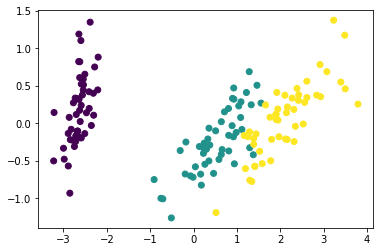

In [ ]:
plt.scatter(x=new_X[:, 0], y=new_X[:, 1], c = y)
plt.show()

# **Kernel PCA**

In [ ]:
kernel_pca = KernelPCA(n_components=2, kernel='rbf', gamma=1)
kernel_pca.fit(X)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=1, kernel='rbf',
          kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

In [ ]:
new_X = kernel_pca.transform(X)

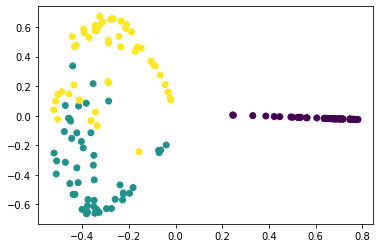

In [ ]:
plt.scatter(x=new_X[:, 0], y=new_X[:, 1], c = y)
plt.show()

# **LDA**

In [ ]:
lda = LDA(solver='svd', n_components=2)
lda.fit(X, y)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
new_X = lda.transform(X)

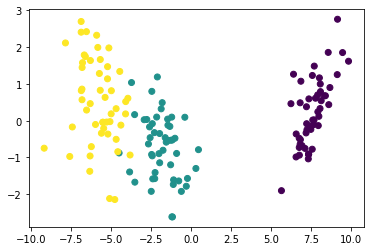

In [ ]:
plt.scatter(x=new_X[:, 0], y=new_X[:, 1], c = y)
plt.show()

# **kernel LDA**

In [ ]:
kernel_lda = dml.kda.KDA(n_components=2, kernel='rbf', gamma=1)

In [ ]:
kernel_lda.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KDA(alpha=None, coef0=None, degree=None, gamma=None, kernel=None,
    kernel_params=None, n_components=None, solver=None, tol=None)

In [ ]:
new_x = kernel_lda.transform(X)

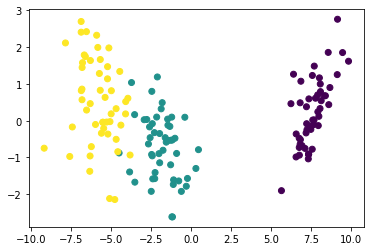

In [ ]:
plt.scatter(x=new_X[:, 0], y=new_X[:, 1], c = y)
plt.show()

# **regression model**

In [ ]:
train1 = data.iloc[0:40]
train2 = data.iloc[50:90]
train3 = data.iloc[100:140]
train = pd.concat([train1, train2, train3], axis=0)

In [ ]:
test1 = data.iloc[40:50]
test2 = data.iloc[90:100]
test3 = data.iloc[140:150]
test = pd.concat([test1, test2, test3], axis=0)

In [ ]:
train_X, train_y = train[[0 ,1, 2, 3]], train['label']
test_X, test_y = test[[0 ,1, 2, 3]], test['label']

**import cvx, and use cvx to construct the structure**

In [49]:
!pip install cvxpy

In [50]:
import cvxpy as cvx

**linear mode**



1.   X.shape = (120, 4), w.shape = (4, ), y.shape=(120, )
2.   minimize using quadratic regularization



In [52]:
train_X.shape

(120, 4)

In [55]:
train_y.shape

(120,)

In [53]:
w = cvx.Variable(4)

In [58]:
X = np.array(train_X.T)
X.shape

(4, 120)

In [83]:
def acc(y_true, y_pred):
  comp = []
  for a, b in zip(y_true, y_pred):
    comp.append(1 if a == b else 0)
  return sum(comp) / len(comp)

In [85]:
Lambda = [0.01, 0.1, 0.5, 1]
for l in Lambda:
  objective = cvx.Minimize(cvx.sum_squares(X.T*w - train_y) + 0.1 * cvx.norm(w))
  prob = cvx.Problem(objective)
  result = prob.solve()
  pred = np.dot(test_X, w.value)
  res = []
  for p in pred:
    if p <= 0.5:
      res.append(0)
    elif p <= 1.5:
      res.append(1)
    else:
      res.append(2)
  res =np.array(res)
  print('lambda = ', l, ' acc is ', acc(test_y, res))

lambda =  0.01  acc is  1.0
lambda =  0.1  acc is  1.0
lambda =  0.5  acc is  1.0
lambda =  1  acc is  1.0


**kernel mode**


*   need to construct a kernel matrix which shape is [120, 120]
*   Xi.T * Xj = Kij 
*   Xi is Ki which shape is (120, 1)



**calculate the kernel mat**

In [132]:
def rbfkernel(distance):
    return np.exp(-0.5 * distance)


In [133]:
def find_distance_matrix(data):
    euclid_distance = []
    for i in data:
        distance = []
        for j in data:
            distance.append(np.linalg.norm(i - j) * np.linalg.norm(i - j))
        distance = np.array(distance)
        euclid_distance.append(distance)
    euclid_distance = np.array(euclid_distance)
    return euclid_distance

In [134]:
distance_mat = find_distance_matrix(train_X.values)

In [136]:
for i in range(120):
  for j in range(120):
    distance_mat[i][j] = rbfkernel(distance_mat[i][j])

In [138]:
K = np.array(distance_mat)

In [140]:
w = cvx.Variable(120)

In [141]:
y = train_y.values

In [146]:
Lambda = [0.01, 0.1, 0.5, 1]
for l in Lambda:
  objective = cvx.Minimize(cvx.sum_squares(K * w - y) + 0.1 * cvx.norm(w))
  prob = cvx.Problem(objective)
  result = prob.solve()
  # make the kernel feature matrix
  mat = []
  for i in test_X.values:
    feature = []
    for j in train_X.values:
      feature.append(rbfkernel(np.linalg.norm(i - j) * np.linalg.norm(i - j)))
    mat.append(np.array(feature))
  mat = np.array(mat)
  pred = np.dot(mat, w.value)
  res = []
  for p in pred:
    if p <= 0.5:
      res.append(0)
    elif p <= 1.5:
      res.append(1)
    else:
      res.append(2)
  res =np.array(res)
  print('lambda = ', l, ' acc is ', acc(test_y, res))

lambda =  0.01  acc is  1.0
lambda =  0.1  acc is  1.0
lambda =  0.5  acc is  1.0
lambda =  1  acc is  1.0
